# Quantitative Momentum Strategy

* source: https://youtu.be/xfzGZB4HhEE?si=p75PeszMBFeDVtiF&t=5927

"Momentum investing" means investing in the stocks that have increased in price the most.

For this project, we're going to build an investing strategy that selects the 50 stocks with the highest price momentum. From there, we will calculate recommended trades for an equal-weight portfolio of these 50 stocks.

## Library Imports

The first thing we need to do is import the open-source software libraries that we'll be using in this tutorial.

In [1]:
import numpy as np
import pandas as pd
import requests
import math
from scipy import stats # calculate percentile score, rank
import xlsxwriter
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

import time
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

# Local variables for API
from config_api_file.secrets import ALPCA_API_KEY, ALPCA_API_SECRET

#### We use paper environment for this example ####
paper = True # Please do not modify this. This example is for paper trading only.
####

# Below are the variables for development this documents
# Please do not change these variables
trade_api_url = None
trade_api_wss = None
data_api_url = None
stream_data_wss = None

# ALPCA specific python SDK (Software Development Kit)
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import GetAssetsRequest
from alpaca.trading.enums import AssetClass


import warnings
warnings.filterwarnings('ignore')


In [2]:
# Mark up the beginning time 

# Start the timer
start_time = time.time()

# Print the current date and time in a human-readable format
current_time = datetime.fromtimestamp(start_time)
current_time_formatted = current_time.strftime("%Y-%m-%d %H:%M:%S")
print("Current date and time:", current_time_formatted)

Current date and time: 2025-04-07 11:07:52


## Get The list of Availabel symbol on NYSE from Alpaca API

- No more uses of flat csv file
- source: https://docs.alpaca.markets/docs/working-with-assets

In [3]:
trading_client = TradingClient(ALPCA_API_KEY, ALPCA_API_SECRET)

# search for US equities
search_params = GetAssetsRequest(asset_class=AssetClass.US_EQUITY)

assets = trading_client.get_all_assets(search_params)

len(assets)

31789

In [4]:
type(assets)

list

In [5]:
assets[0]

{   'asset_class': <AssetClass.US_EQUITY: 'us_equity'>,
    'attributes': [],
    'easy_to_borrow': False,
    'exchange': <AssetExchange.OTC: 'OTC'>,
    'fractionable': False,
    'id': UUID('a67a6f1a-885e-4079-af77-2577e02c0a09'),
    'maintenance_margin_requirement': 100.0,
    'marginable': False,
    'min_order_size': None,
    'min_trade_increment': None,
    'name': 'Kneat Com Inc Ordinary Shares',
    'price_increment': None,
    'shortable': False,
    'status': <AssetStatus.INACTIVE: 'inactive'>,
    'symbol': 'KSIOF',
    'tradable': False}

In [6]:
type(assets[0])

alpaca.trading.models.Asset

In [7]:
assets[0].dict

<bound method BaseModel.dict of {   'asset_class': <AssetClass.US_EQUITY: 'us_equity'>,
    'attributes': [],
    'easy_to_borrow': False,
    'exchange': <AssetExchange.OTC: 'OTC'>,
    'fractionable': False,
    'id': UUID('a67a6f1a-885e-4079-af77-2577e02c0a09'),
    'maintenance_margin_requirement': 100.0,
    'marginable': False,
    'min_order_size': None,
    'min_trade_increment': None,
    'name': 'Kneat Com Inc Ordinary Shares',
    'price_increment': None,
    'shortable': False,
    'status': <AssetStatus.INACTIVE: 'inactive'>,
    'symbol': 'KSIOF',
    'tradable': False}>

In [8]:
# type(assets[0])
# alpaca.trading.models.Asset

# Assuming `assets` is your list of Asset objects
# For example:
# from alpaca.trading.client import TradingClient
# trading_client = TradingClient(API_KEY, API_SECRET)
# assets = trading_client.get_all_assets()

# Extract attributes from each Asset object
asset_dicts = [asset.__dict__ for asset in assets]

# Convert to DataFrame
df = pd.DataFrame(asset_dicts)

# Optional: Display only the columns you're interested in
df_filtered = df[['symbol', 'name', 'asset_class', 'attributes', 'exchange',  'status', 'tradable']]

# set index to symbol
df_filtered.set_index('symbol', inplace=True)
df_filtered

,name,asset_class,attributes,exchange,status,tradable
symbol,,,,,,
KSIOF,Kneat Com Inc Ordinary Shares,AssetClass.US_EQUITY,[],AssetExchange.OTC,AssetStatus.INACTIVE,False
KOREF,KORE MNG LTD NEW Ordinary Shares,AssetClass.US_EQUITY,[],AssetExchange.OTC,AssetStatus.INACTIVE,False
TERRF,Trasmissione Elettricita Rete Nazionale Spa Ro...,AssetClass.US_EQUITY,[],AssetExchange.OTC,AssetStatus.INACTIVE,False
SRE.PRB,Sempra 6.75% Mandatory Convertible Preferred S...,AssetClass.US_EQUITY,[],AssetExchange.NYSE,AssetStatus.INACTIVE,False
LGCFF,LAVRAS GOLD CORP Common Shares,AssetClass.US_EQUITY,[],AssetExchange.OTC,AssetStatus.INACTIVE,False
...,...,...,...,...,...,...
ECOW,Pacer Funds Pacer Emerging Markets Cash Cows 1...,AssetClass.US_EQUITY,"[fractional_eh_enabled, has_options]",AssetExchange.NASDAQ,AssetStatus.ACTIVE,True
ECXWW,ECARX Holdings Inc. Warrants,AssetClass.US_EQUITY,[],AssetExchange.NASDAQ,AssetStatus.ACTIVE,True
EDAP,EDAP TMS S.A. American Depositary Shares,AssetClass.US_EQUITY,"[fractional_eh_enabled, has_options]",AssetExchange.NASDAQ,AssetStatus.ACTIVE,True


In [9]:
# Filter for only active and tradable assets
df_filtered_active_tradable = df_filtered[(df_filtered['status'] == 'active') & (df_filtered['tradable'] == True)]
df_filtered_active_tradable

,name,asset_class,attributes,exchange,status,tradable
symbol,,,,,,
EDBLW,Edible Garden AG Incorporated Warrant,AssetClass.US_EQUITY,[],AssetExchange.NASDAQ,AssetStatus.ACTIVE,True
EDD,Morgan Stanley Emerging Markets Domestic Debt ...,AssetClass.US_EQUITY,[],AssetExchange.NYSE,AssetStatus.ACTIVE,True
EDEN,iShares MSCI Denmark ETF,AssetClass.US_EQUITY,[fractional_eh_enabled],AssetExchange.BATS,AssetStatus.ACTIVE,True
EDF,Virtus Stone Harbor Emerging Markets Income Fund,AssetClass.US_EQUITY,[],AssetExchange.NYSE,AssetStatus.ACTIVE,True
EDGH,3EDGE Dynamic Hard Assets ETF,AssetClass.US_EQUITY,[],AssetExchange.ARCA,AssetStatus.ACTIVE,True
...,...,...,...,...,...,...
ECOW,Pacer Funds Pacer Emerging Markets Cash Cows 1...,AssetClass.US_EQUITY,"[fractional_eh_enabled, has_options]",AssetExchange.NASDAQ,AssetStatus.ACTIVE,True
ECXWW,ECARX Holdings Inc. Warrants,AssetClass.US_EQUITY,[],AssetExchange.NASDAQ,AssetStatus.ACTIVE,True
EDAP,EDAP TMS S.A. American Depositary Shares,AssetClass.US_EQUITY,"[fractional_eh_enabled, has_options]",AssetExchange.NASDAQ,AssetStatus.ACTIVE,True


In [10]:
# Group by 'exchange' and count the number of stocks
stock_count_by_exchange = df_filtered_active_tradable.groupby('exchange').size()


# Or you can use count() if you want to count non-null entries for a specific column
# stock_count_by_exchange = df_filtered_active_tradable.groupby('exchange')['name'].count()

# Convert the result into a DataFrame and assign a name to the column
stock_count_by_exchange_df = stock_count_by_exchange.reset_index(name="Count")

# Print the result
stock_count_by_exchange_df

,exchange,Count
0,AssetExchange.AMEX,289
1,AssetExchange.ARCA,2319
2,AssetExchange.BATS,950
3,AssetExchange.NASDAQ,4780
4,AssetExchange.NYSE,2873
5,AssetExchange.OTC,280


In [11]:
# Filter for a particular excange (e.g. NYSE) ACTIVE assets
df_filtered_active_tradable_exchange = df_filtered_active_tradable[df_filtered_active_tradable['exchange'] == 
                                                                   'NYSE']
df_filtered_active_tradable_exchange

,name,asset_class,attributes,exchange,status,tradable
symbol,,,,,,
EDD,Morgan Stanley Emerging Markets Domestic Debt ...,AssetClass.US_EQUITY,[],AssetExchange.NYSE,AssetStatus.ACTIVE,True
EDF,Virtus Stone Harbor Emerging Markets Income Fund,AssetClass.US_EQUITY,[],AssetExchange.NYSE,AssetStatus.ACTIVE,True
EDN,Empresa Distribuidora Y Comercializadora Norte...,AssetClass.US_EQUITY,[fractional_eh_enabled],AssetExchange.NYSE,AssetStatus.ACTIVE,True
EFC.PRA,Ellington Financial Inc. 6.750% Series A Fixed...,AssetClass.US_EQUITY,[],AssetExchange.NYSE,AssetStatus.ACTIVE,True
EFC.PRB,Ellington Financial Inc. 6.250% Series B Fixed...,AssetClass.US_EQUITY,[],AssetExchange.NYSE,AssetStatus.ACTIVE,True
...,...,...,...,...,...,...
QXO,"QXO, Inc.",AssetClass.US_EQUITY,"[fractional_eh_enabled, has_options]",AssetExchange.NYSE,AssetStatus.ACTIVE,True
PHI,PLDT Inc.,AssetClass.US_EQUITY,[fractional_eh_enabled],AssetExchange.NYSE,AssetStatus.ACTIVE,True
AOMR,"Angel Oak Mortgage REIT, Inc.",AssetClass.US_EQUITY,[],AssetExchange.NYSE,AssetStatus.ACTIVE,True


In [12]:
# save to xlsx
# df_filtered_active_tradable_exchange.to_excel('df_filtered_active_tradable_nyse.xlsx')

# Get historical bars by symbol

ref. https://docs.alpaca.markets/reference/stockbars-1

## Test with 3 stocks example

In [13]:
stock_historical_data_client = StockHistoricalDataClient(ALPCA_API_KEY, ALPCA_API_SECRET, 
                                                         url_override = data_api_url)

# now = datetime.now(ZoneInfo("America/New_York"))
now = datetime.now(ZoneInfo("Europe/London"))

req = StockBarsRequest(
    symbol_or_symbols = ['AAPL', 'TSLA', 'JPM', 'MSFT'],

    # timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Week), # specify timeframe
    timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Day), # specify timeframe 
    
    #start = now - timedelta(weeks = 54),                          # specify start datetime, default=the beginning of the current day.
    start = now - timedelta(days = 365), # specify start datetime, default=the beginning of the current day.
    
    #end_date= now - timedelta(days = 1),                                        # specify end datetime, default=now
    end_date= now,                       # specify end datetime, default=now

    # limit = 100,                                               # specify limit
)

# Assuming df is the DataFrame name
df_historical_data_example = stock_historical_data_client.get_stock_bars(req).df

df_historical_data_example.shape

(1000, 7)

In [14]:
def graph_evolution_per_timestamp(df, selected_field='close', normalize_to_first = True): 
   
    # Extract the attribute (default value is'close') column from the DataFrame

    # Pivot the DataFrame to have 'symbol' as columns and 'timestamp' as index
    df_pivot = df[selected_field].unstack(level='symbol')
    
    if normalize_to_first:
        df_pivot = df_pivot.div(df_pivot.iloc[0]).mul(100)

    # Plot the data for all symbols
    df_pivot.plot(figsize=(12, 6))

    # Customize the plot
    plt.title(f'{selected_field} [Price] of Stocks Over Time - Normalized to start a 100 = {normalize_to_first} ')
    plt.xlabel('Date')
    plt.ylabel(f'{selected_field} [Price ($)]')
    plt.legend(title='Symbol')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()

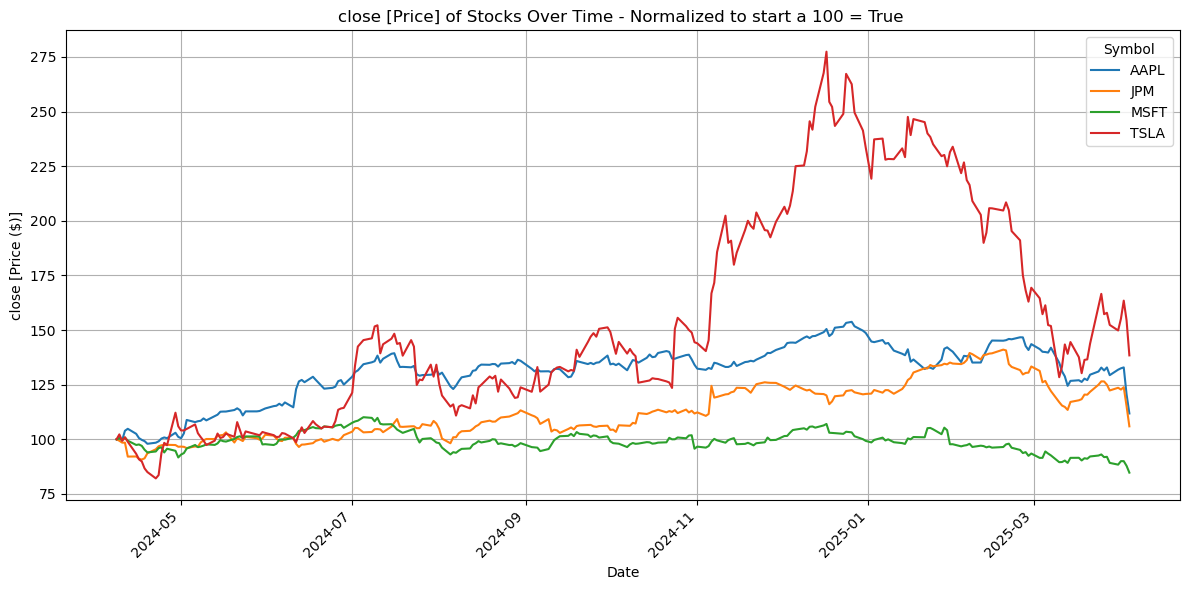

In [15]:
graph_evolution_per_timestamp(df_historical_data_example)

In [16]:
df_historical_data_excel = df_historical_data_example
df_historical_data_excel = df_historical_data_excel.unstack()['close'].transpose()
df_historical_data_excel.reset_index(inplace=True)
df_historical_data_excel.head()

symbol,timestamp,AAPL,JPM,MSFT,TSLA
0,2024-04-08 04:00:00+00:00,168.45,198.48,424.59,172.98
1,2024-04-09 04:00:00+00:00,169.67,197.15,426.28,176.88
2,2024-04-10 04:00:00+00:00,167.78,195.47,423.26,171.76
3,2024-04-11 04:00:00+00:00,175.04,195.43,427.93,174.60
4,2024-04-12 04:00:00+00:00,176.55,182.79,421.90,171.05


In [17]:
# Convert any timezone-aware datetime columns to timezone-unaware
# df_historical_data_excel['timestamp'] = df_historical_data_excel['timestamp'].dt.tz_localize(None)

# Now you can save the DataFrame to Excel
# df_historical_data_excel.to_excel("df_historical_data_excel.xlsx")

## Exectuting on a batch API of full selected active stock from the exchange

In [18]:
len(df_filtered_active_tradable_exchange.index.to_list())

2873

In [19]:
stock_historical_data_client = StockHistoricalDataClient(ALPCA_API_KEY, ALPCA_API_SECRET, 
                                                         url_override = data_api_url)

# now = datetime.now(ZoneInfo("America/New_York"))
now = datetime.now(ZoneInfo("Europe/London"))

# Significant optimization possible as we do not need all the daily data for our momemtum analysis
# take 2 min for now so no need to review yet
req = StockBarsRequest(
    symbol_or_symbols = df_filtered_active_tradable_exchange.index.to_list(),
    timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Day), # specify timeframe 
    start = now - timedelta(days = 365), # specify start datetime, default=the beginning of the current day.
    end_date= now,                       # specify end datetime, default=now
    # limit = 100,                                               # specify limit
)

# Assuming df is the DataFrame name
df_historical_data = stock_historical_data_client.get_stock_bars(req).df

df_historical_data.shape

(704640, 7)

In [20]:
df_historical_data.head()

open   high    low  close  volume  \
symbol timestamp                                                       
AACT.U 2024-04-08 04:00:00+00:00  10.59  10.59  10.59  10.59     0.0   
       2024-04-09 04:00:00+00:00  10.59  10.59  10.59  10.59     0.0   
       2024-04-10 04:00:00+00:00  10.59  10.59  10.59  10.59     0.0   
       2024-04-11 04:00:00+00:00  10.59  10.59  10.59  10.59     0.0   
       2024-04-12 04:00:00+00:00  10.59  10.59  10.59  10.59     0.0   

                                  trade_count  vwap  
symbol timestamp                                     
AACT.U 2024-04-08 04:00:00+00:00          0.0   0.0  
       2024-04-09 04:00:00+00:00          0.0   0.0  
       2024-04-10 04:00:00+00:00          0.0   0.0  
       2024-04-11 04:00:00+00:00          0.0   0.0  
       2024-04-12 04:00:00+00:00          0.0   0.0

In [21]:
df_historical_data.unstack()['close'].tail()

timestamp,2024-04-08 04:00:00+00:00,2024-04-09 04:00:00+00:00,2024-04-10 04:00:00+00:00,2024-04-11 04:00:00+00:00,2024-04-12 04:00:00+00:00,2024-04-15 04:00:00+00:00,2024-04-16 04:00:00+00:00,2024-04-17 04:00:00+00:00,2024-04-18 04:00:00+00:00,2024-04-19 04:00:00+00:00,...,2025-03-24 04:00:00+00:00,2025-03-25 04:00:00+00:00,2025-03-26 04:00:00+00:00,2025-03-27 04:00:00+00:00,2025-03-28 04:00:00+00:00,2025-03-31 04:00:00+00:00,2025-04-01 04:00:00+00:00,2025-04-02 04:00:00+00:00,2025-04-03 04:00:00+00:00,2025-04-04 04:00:00+00:00
symbol,,,,,,,,,,,,,,,,,,,,,
ZTO,20.74,20.48,20.42,20.17,19.26,19.54,19.36,19.31,20.00,19.9400,...,19.98,19.82,19.88,20.21,19.82,19.84,19.83,19.48,19.110,18.17
ZTR,5.48,5.50,5.43,5.42,5.36,5.33,5.25,5.30,5.29,5.3200,...,5.93,5.89,5.91,5.93,5.92,5.97,5.99,6.00,5.955,5.60
ZTS,165.69,167.14,163.20,162.73,149.98,149.77,153.02,151.94,153.11,146.5000,...,163.17,161.30,162.82,165.02,163.11,164.65,161.91,163.50,159.610,151.73
ZVIA,1.18,1.07,1.05,1.08,1.03,0.98,1.00,1.01,0.96,0.9831,...,2.21,2.14,2.08,2.13,2.08,2.16,2.20,2.39,2.170,2.08
ZWS,31.99,32.52,31.76,32.20,31.91,31.66,31.72,31.28,31.61,31.6900,...,34.35,34.22,33.96,33.76,32.96,32.98,33.16,33.49,30.660,29.65


In [22]:
df_historical_data_close_transpose = df_historical_data.unstack()['close'].transpose()
df_historical_data_close_transpose.head()

symbol,A,AA,AACT,AACT.U,AACT.WS,AAM,AAM.U,AAM.WS,AAMI,AAP,...,ZH,ZIM,ZIP,ZK,ZKH,ZTO,ZTR,ZTS,ZVIA,ZWS
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-04-08 04:00:00+00:00,144.46,36.34,10.585,10.59,0.21,NaN,NaN,NaN,22.99,78.13,...,0.7132,10.96,11.41,NaN,16.39,20.74,5.48,165.69,1.18,31.99
2024-04-09 04:00:00+00:00,147.40,36.82,10.590,10.59,0.21,NaN,NaN,NaN,22.94,78.46,...,0.7170,10.38,11.59,NaN,17.19,20.48,5.50,167.14,1.07,32.52
2024-04-10 04:00:00+00:00,144.16,36.19,10.590,10.59,0.21,NaN,NaN,NaN,22.65,77.95,...,0.7150,10.42,11.34,NaN,16.54,20.42,5.43,163.20,1.05,31.76
2024-04-11 04:00:00+00:00,145.00,36.23,10.620,10.59,0.21,NaN,NaN,NaN,22.59,74.35,...,0.7201,10.69,11.34,NaN,15.95,20.17,5.42,162.73,1.08,32.20
2024-04-12 04:00:00+00:00,140.73,35.20,10.610,10.59,0.18,NaN,NaN,NaN,22.35,70.50,...,0.6999,10.10,11.19,NaN,14.78,19.26,5.36,149.98,1.03,31.91


In [23]:
# clean to remove NaN
df_historical_data_close_transpose = df_historical_data_close_transpose.dropna(axis=1)
df_historical_data_close_transpose.reset_index(inplace=True)
df_historical_data_close_transpose

symbol,timestamp,A,AA,AACT,AACT.U,AACT.WS,AAMI,AAP,AAT,AB,...,ZGN,ZH,ZIM,ZIP,ZKH,ZTO,ZTR,ZTS,ZVIA,ZWS
0,2024-04-08 04:00:00+00:00,144.46,36.34,10.585,10.59,0.2100,22.99,78.13,21.42,34.98,...,12.17,0.7132,10.96,11.41,16.3900,20.74,5.480,165.69,1.18,31.99
1,2024-04-09 04:00:00+00:00,147.40,36.82,10.590,10.59,0.2100,22.94,78.46,22.27,34.47,...,12.01,0.7170,10.38,11.59,17.1900,20.48,5.500,167.14,1.07,32.52
2,2024-04-10 04:00:00+00:00,144.16,36.19,10.590,10.59,0.2100,22.65,77.95,20.81,33.26,...,11.67,0.7150,10.42,11.34,16.5400,20.42,5.430,163.20,1.05,31.76
3,2024-04-11 04:00:00+00:00,145.00,36.23,10.620,10.59,0.2100,22.59,74.35,21.04,33.09,...,11.67,0.7201,10.69,11.34,15.9500,20.17,5.420,162.73,1.08,32.20
4,2024-04-12 04:00:00+00:00,140.73,35.20,10.610,10.59,0.1800,22.35,70.50,20.77,33.15,...,11.31,0.6999,10.10,11.19,14.7800,19.26,5.360,149.98,1.03,31.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2025-03-31 04:00:00+00:00,116.98,30.50,11.150,11.20,0.2900,25.86,39.21,20.14,38.31,...,7.40,4.2700,14.59,5.89,3.3500,19.84,5.970,164.65,2.16,32.98
246,2025-04-01 04:00:00+00:00,114.05,30.14,11.140,11.43,0.3000,26.34,39.02,20.07,38.47,...,7.37,4.3100,15.46,6.19,3.5100,19.83,5.990,161.91,2.20,33.16
247,2025-04-02 04:00:00+00:00,115.99,30.84,11.150,11.43,0.3100,26.58,39.32,20.40,39.01,...,7.38,4.1500,16.13,6.27,3.5300,19.48,6.000,163.50,2.39,33.49
248,2025-04-03 04:00:00+00:00,109.67,27.33,11.140,11.43,0.3255,24.25,36.62,19.37,37.90,...,6.47,4.1400,13.49,5.56,3.4809,19.11,5.955,159.61,2.17,30.66


In [24]:
data_cleaned = df_historical_data_close_transpose

# Ensure your 'timestamp' column is in datetime format
data_cleaned['timestamp'] = pd.to_datetime(data_cleaned['timestamp'])

# Set the timestamp as the index if it's not already
data_cleaned.set_index('timestamp', inplace=True)

data_cleaned.tail()

symbol,A,AA,AACT,AACT.U,AACT.WS,AAMI,AAP,AAT,AB,ABBV,...,ZGN,ZH,ZIM,ZIP,ZKH,ZTO,ZTR,ZTS,ZVIA,ZWS
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-31 04:00:00+00:00,116.98,30.50,11.15,11.20,0.2900,25.86,39.21,20.14,38.31,209.52,...,7.40,4.27,14.59,5.89,3.3500,19.84,5.970,164.65,2.16,32.98
2025-04-01 04:00:00+00:00,114.05,30.14,11.14,11.43,0.3000,26.34,39.02,20.07,38.47,206.27,...,7.37,4.31,15.46,6.19,3.5100,19.83,5.990,161.91,2.20,33.16
2025-04-02 04:00:00+00:00,115.99,30.84,11.15,11.43,0.3100,26.58,39.32,20.40,39.01,205.19,...,7.38,4.15,16.13,6.27,3.5300,19.48,6.000,163.50,2.39,33.49
2025-04-03 04:00:00+00:00,109.67,27.33,11.14,11.43,0.3255,24.25,36.62,19.37,37.90,201.64,...,6.47,4.14,13.49,5.56,3.4809,19.11,5.955,159.61,2.17,30.66
2025-04-04 04:00:00+00:00,103.00,24.81,11.17,11.43,0.2900,22.96,35.01,18.73,36.17,186.96,...,6.60,3.85,12.52,5.21,3.3350,18.17,5.600,151.73,2.08,29.65


In [25]:
# Function to calculate return over different periods
def calculate_returns(data_cleaned):
    # Create a dictionary to store the returns for each period
    returns = {}

    # Calculate 1-day return (direct pct_change)
    returns["1-day Return"] = data_cleaned.pct_change(periods=1).iloc[-1]

    # Calculate 1-week return (using resample('W') to get weekly data)
    returns["1-week Return"] = data_cleaned.resample('W').last().pct_change(periods=1).iloc[-1]

    # Calculate 1-month return (using resample('M') to get monthly data)
    returns["1-month Return"] = data_cleaned.resample('M').last().pct_change(periods=1).iloc[-1]

    # Calculate 3-month return (using resample('Q') to get quarterly data)
    returns["3-month Return"] = data_cleaned.resample('Q').last().pct_change(periods=1).iloc[-1]

    # Calculate 6-month return (using resample('6M') to get 6-monthly data)
    returns["6-month Return"] = data_cleaned.resample('6M').last().pct_change(periods=1).iloc[-1]

    # Calculate 1-year return (using resample('A') to get annual data)
    returns["1-year Return"] = data_cleaned.resample('A').last().pct_change(periods=1).iloc[-1]

    # Convert the dictionary into a DataFrame
    return pd.DataFrame(returns)

In [26]:
# Call the function to compute returns
data_returns = calculate_returns(data_cleaned)

# Show the returns DataFrame
data_returns

,1-day Return,1-week Return,1-month Return,3-month Return,6-month Return,1-year Return
symbol,,,,,,
A,-0.060819,-0.117319,-0.119508,-0.119508,-0.209577,-0.233289
AA,-0.092206,-0.190802,-0.186557,-0.186557,-0.381142,-0.343303
AACT,0.002693,0.000000,0.001794,0.001794,0.026654,0.017304
AACT.U,0.000000,0.020536,0.020536,0.020536,0.044790,0.030658
AACT.WS,-0.109063,0.035714,0.000000,0.000000,0.478837,0.933333
...,...,...,...,...,...,...
ZTO,-0.049189,-0.083249,-0.084173,-0.084173,-0.213760,-0.070588
ZTR,-0.059614,-0.054054,-0.061977,-0.061977,-0.050847,-0.044369
ZTS,-0.049370,-0.069769,-0.078469,-0.078469,-0.151303,-0.068741


## Building a Better (and More Realistic) Momentum Strategy

Real-world quantitative investment firms differentiate between "high quality" and "low quality" momentum stocks:

* High-quality momentum stocks show "slow and steady" outperformance over long periods of time
* Low-quality momentum stocks might not show any momentum for a long time, and then surge upwards.

The reason why high-quality momentum stocks are preferred is because low-quality momentum can often be cause by short-term news that is unlikely to be repeated in the future (such as an FDA approval for a biotechnology company).

To identify high-quality momentum, we're going to build a strategy that selects stocks from the highest percentiles of: 

* 1-day price return
* 1-week price returns
* 1-month price returns
* 3-month price returns
* 6-month price returns
* 1-year price returns

Let's start by building our DataFrame. You'll notice that I use the abbreviation `hqm` often. It stands for `high-quality momentum`.

### Calculating Momentum Percentiles

We now need to calculate momentum percentile scores for every stock in the universe. More specifically, we need to calculate percentile scores for the following metrics for every stock:

* `One-Year Price Return`
* `Six-Month Price Return`
* `Three-Month Price Return`
* `One-Month Price Return`

Here's how we'll do this:

In [27]:
# Function to calculate percentile for each value in the series
def calculate_percentile(series):
    return series.apply(lambda x: stats.percentileofscore(series, x))/100

In [28]:
# Apply to multiple columns
final_data_percentiles = data_returns.apply(calculate_percentile)

final_data_percentiles.columns = [col + ' Percentile' for col in data_returns.columns]
final_data_percentiles

,1-day Return Percentile,1-week Return Percentile,1-month Return Percentile,3-month Return Percentile,6-month Return Percentile,1-year Return Percentile
symbol,,,,,,
A,0.323785,0.246193,0.223713,0.223713,0.247281,0.210297
AA,0.103336,0.059826,0.054025,0.054025,0.077955,0.092458
AACT,0.931835,0.933648,0.944888,0.944888,0.850254,0.844815
AACT.U,0.908086,0.982959,0.985134,0.985134,0.870921,0.873096
AACT.WS,0.050036,0.991661,0.930384,0.930384,0.980058,0.996737
...,...,...,...,...,...,...
ZTO,0.442712,0.441987,0.428934,0.428934,0.240754,0.534083
ZTR,0.335025,0.617476,0.567078,0.567078,0.655547,0.621465
ZTS,0.440537,0.528281,0.464830,0.464830,0.360769,0.540972


## Calculating the HQM Score

We'll now calculate our `HQM Score`, which is the high-quality momentum score that we'll use to filter for stocks in this investing strategy.

The `HQM Score` will be the arithmetic mean of the 4 momentum percentile scores that we calculated in the last section.

To calculate arithmetic mean, we will use the `mean` function from Python's built-in `statistics` module.

In [29]:
final_data_percentiles['HQM Score'] = final_data_percentiles.mean(axis=1)
final_data_percentiles

,1-day Return Percentile,1-week Return Percentile,1-month Return Percentile,3-month Return Percentile,6-month Return Percentile,1-year Return Percentile,HQM Score
symbol,,,,,,,
A,0.323785,0.246193,0.223713,0.223713,0.247281,0.210297,0.245830
AA,0.103336,0.059826,0.054025,0.054025,0.077955,0.092458,0.073604
AACT,0.931835,0.933648,0.944888,0.944888,0.850254,0.844815,0.908388
AACT.U,0.908086,0.982959,0.985134,0.985134,0.870921,0.873096,0.934222
AACT.WS,0.050036,0.991661,0.930384,0.930384,0.980058,0.996737,0.813210
...,...,...,...,...,...,...,...
ZTO,0.442712,0.441987,0.428934,0.428934,0.240754,0.534083,0.419567
ZTR,0.335025,0.617476,0.567078,0.567078,0.655547,0.621465,0.560612
ZTS,0.440537,0.528281,0.464830,0.464830,0.360769,0.540972,0.466703


## Selecting the 10 Best and worst Momentum Stocks

As before, we can identify the 50 best momentum stocks in our universe by sorting the DataFrame on the `HQM Score` column and dropping all but the top 50 entries.

In [30]:
final_data_complete = pd.concat([data_returns, final_data_percentiles], axis=1)
final_data_complete['Last Price'] = data_cleaned.iloc[-1]
final_data_complete.sort_values('HQM Score', inplace=True, ascending=False)
final_data_complete

,1-day Return,1-week Return,1-month Return,3-month Return,6-month Return,1-year Return,1-day Return Percentile,1-week Return Percentile,1-month Return Percentile,3-month Return Percentile,6-month Return Percentile,1-year Return Percentile,HQM Score,Last Price
symbol,,,,,,,,,,,,,,
LOCL,0.684397,1.357320,1.305825,1.305825,0.900000,1.294686,1.000000,1.000000,1.000000,1.000000,0.990210,0.998187,0.998066,4.7500
NE.WS,0.028555,0.092177,0.092177,0.092177,0.161935,0.466923,0.976795,0.995286,0.995649,0.995649,0.940174,0.992748,0.982717,18.0100
AMPS,0.004032,0.008097,0.006061,0.006061,0.447674,0.223587,0.942531,0.963379,0.962292,0.962292,0.978970,0.973532,0.963832,4.9800
LITB,0.000000,0.597421,0.115000,0.115000,0.027650,0.327381,0.908086,0.999637,0.997825,0.997825,0.851342,0.987310,0.957004,2.2300
VHC,-0.015556,0.173510,0.198917,0.198917,0.390895,0.128662,0.771574,0.998187,0.998912,0.998912,0.976432,0.952139,0.949359,8.8600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NBR,-0.210742,-0.306421,-0.305922,-0.305922,-0.610939,-0.493616,0.002538,0.007252,0.005076,0.005076,0.013416,0.026831,0.010031,28.9500
KOS,-0.155556,-0.315315,-0.333333,-0.333333,-0.595745,-0.555556,0.011240,0.006164,0.003988,0.003988,0.014866,0.015591,0.009306,1.5200
SST.WS,-0.261905,-0.688442,-0.688442,-0.688442,-0.752000,-0.655556,0.001450,0.000363,0.000363,0.000363,0.005076,0.006889,0.002417,0.0062


In [31]:
# definition of toolkits function 
def join_on_key_and_save_with_time_marker(df_filtered, final_data_complete, current_time_formatted, 
                                          up_or_bottom="None"):
    
    if up_or_bottom == "bottom10": 
        # Join the DataFrames on the 'key' column (default is an inner join)
        df1 = df_filtered.loc[final_data_complete.tail(10).index]
        df2 = final_data_complete.tail(10)
        
    elif up_or_bottom == "top10": 
         # Join the DataFrames on the 'key' column (default is an inner join)
        df1 = df_filtered.loc[final_data_complete.head(10).index]
        df2 = final_data_complete.head(10)
    else:
         # Join the DataFrames on the 'key' column (default is an inner join)
        df1 = df_filtered.loc[final_data_complete.index]
        df2 = final_data_complete

    df_merged = pd.merge(df1, df2, left_index=True, right_index=True, how='inner')

    # clean time marker after 3 consecutive split with different seperator
    current_time_formatted_file = "".join(current_time_formatted.split(":")) 
    current_time_formatted_file = "".join(current_time_formatted_file.split("-"))
    current_time_formatted_file = "".join(current_time_formatted_file.split(" "))

    filename = f"{up_or_bottom}_data_{current_time_formatted_file}"
    df_merged.to_excel(f'output/momentum_strategy_{filename}.xlsx', index=True, index_label=True)
    
    return df_merged

### Top

In [32]:
# Save and display top 10
join_on_key_and_save_with_time_marker(df_filtered, final_data_complete, current_time_formatted, 
                                          up_or_bottom="top10")

,name,asset_class,attributes,exchange,status,tradable,1-day Return,1-week Return,1-month Return,3-month Return,6-month Return,1-year Return,1-day Return Percentile,1-week Return Percentile,1-month Return Percentile,3-month Return Percentile,6-month Return Percentile,1-year Return Percentile,HQM Score,Last Price
symbol,,,,,,,,,,,,,,,,,,,,
LOCL,Local Bounti Corporation,AssetClass.US_EQUITY,[],AssetExchange.NYSE,AssetStatus.ACTIVE,True,0.684397,1.357320,1.305825,1.305825,0.900000,1.294686,1.000000,1.000000,1.000000,1.000000,0.990210,0.998187,0.998066,4.7500
NE.WS,Noble Corporation plc Tranche 1 Warrants,AssetClass.US_EQUITY,[],AssetExchange.NYSE,AssetStatus.ACTIVE,True,0.028555,0.092177,0.092177,0.092177,0.161935,0.466923,0.976795,0.995286,0.995649,0.995649,0.940174,0.992748,0.982717,18.0100
AMPS,"Altus Power, Inc.",AssetClass.US_EQUITY,"[fractional_eh_enabled, has_options]",AssetExchange.NYSE,AssetStatus.ACTIVE,True,0.004032,0.008097,0.006061,0.006061,0.447674,0.223587,0.942531,0.963379,0.962292,0.962292,0.978970,0.973532,0.963832,4.9800
LITB,"LightInTheBox Holding Co., Ltd. American Depos...",AssetClass.US_EQUITY,[],AssetExchange.NYSE,AssetStatus.ACTIVE,True,0.000000,0.597421,0.115000,0.115000,0.027650,0.327381,0.908086,0.999637,0.997825,0.997825,0.851342,0.987310,0.957004,2.2300
VHC,VirnetX Holding Corporation,AssetClass.US_EQUITY,[has_options],AssetExchange.NYSE,AssetStatus.ACTIVE,True,-0.015556,0.173510,0.198917,0.198917,0.390895,0.128662,0.771574,0.998187,0.998912,0.998912,0.976432,0.952139,0.949359,8.8600
TISI,"Team, Inc.",AssetClass.US_EQUITY,[],AssetExchange.NYSE,AssetStatus.ACTIVE,True,0.053444,0.126031,0.130024,0.130024,-0.034831,0.507886,0.992023,0.996737,0.998187,0.998187,0.708122,0.993836,0.947849,19.1200
RKT,"Rocket Companies, Inc.",AssetClass.US_EQUITY,"[fractional_eh_enabled, has_options]",AssetExchange.NYSE,AssetStatus.ACTIVE,True,0.111913,0.181888,0.275891,0.275891,-0.043478,0.367673,0.997099,0.998550,0.999637,0.999637,0.680928,0.989485,0.944223,15.4000
GUT.PRC,Gabelli Utility Trust 5.375% Series C Cumula...,AssetClass.US_EQUITY,[],AssetExchange.NYSE,AssetStatus.ACTIVE,True,0.032363,0.026057,0.035804,0.035804,0.023016,0.024019,0.980058,0.986222,0.990210,0.990210,0.844453,0.858593,0.941624,24.8593
FNA,"Paragon 28, Inc.",AssetClass.US_EQUITY,"[fractional_eh_enabled, has_options]",AssetExchange.NYSE,AssetStatus.ACTIVE,True,-0.001530,0.000767,-0.000766,-0.000766,1.462264,0.263311,0.887600,0.937273,0.924220,0.924220,0.994199,0.980783,0.941383,13.0500


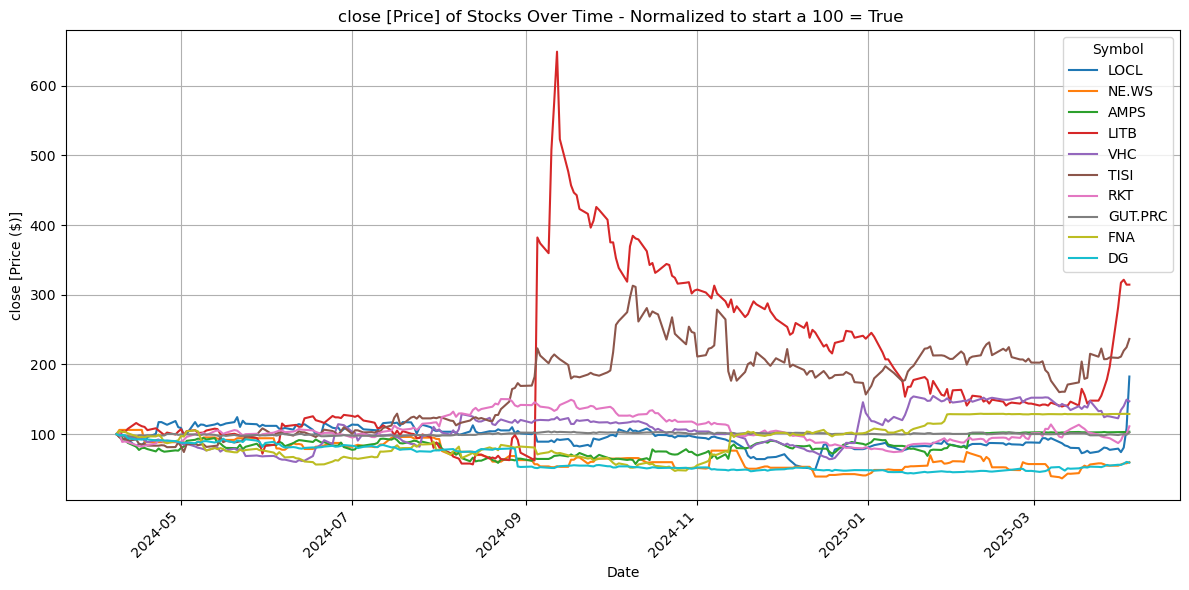

In [33]:
# Using loc to filter by the first level
# for other level use xs()
df_historical_data_top10 = df_historical_data.loc[final_data_complete.head(10).index]
graph_evolution_per_timestamp(df_historical_data_top10)

### Worst

In [34]:
# Save and display bottom 10
join_on_key_and_save_with_time_marker(df_filtered, final_data_complete, current_time_formatted, 
                                          up_or_bottom="bottom10")

,name,asset_class,attributes,exchange,status,tradable,1-day Return,1-week Return,1-month Return,3-month Return,6-month Return,1-year Return,1-day Return Percentile,1-week Return Percentile,1-month Return Percentile,3-month Return Percentile,6-month Return Percentile,1-year Return Percentile,HQM Score,Last Price
symbol,,,,,,,,,,,,,,,,,,,,
EAF,GrafTech International Ltd.,AssetClass.US_EQUITY,"[fractional_eh_enabled, has_options]",AssetExchange.NYSE,AssetStatus.ACTIVE,True,-0.138473,-0.290961,-0.229414,-0.229414,-0.603647,-0.610520,0.019217,0.010515,0.020305,0.020305,0.014141,0.009427,0.015651,0.6738
CIVI,"Civitas Resources, Inc.",AssetClass.US_EQUITY,[],AssetExchange.NYSE,AssetStatus.INACTIVE,False,-0.172461,-0.306682,-0.304099,-0.304099,-0.502357,-0.470678,0.006164,0.006889,0.005801,0.005801,0.028644,0.030457,0.013959,24.2800
CIVI,"Civitas Resources, Inc.",AssetClass.US_EQUITY,"[fractional_eh_enabled, has_options]",AssetExchange.NYSE,AssetStatus.ACTIVE,True,-0.172461,-0.306682,-0.304099,-0.304099,-0.502357,-0.470678,0.006164,0.006889,0.005801,0.005801,0.028644,0.030457,0.013959,24.2800
NPWR.WS,"NET Power Inc. Redeemable warrants, each whole...",AssetClass.US_EQUITY,[],AssetExchange.NYSE,AssetStatus.ACTIVE,True,-0.105067,-0.347458,-0.368852,-0.368852,-0.918137,-0.946517,0.061276,0.003988,0.003263,0.003263,0.001088,0.000363,0.012207,0.1925
VTLE,"Vital Energy, Inc.",AssetClass.US_EQUITY,"[fractional_eh_enabled, has_options]",AssetExchange.NYSE,AssetStatus.ACTIVE,True,-0.169643,-0.352968,-0.342601,-0.342601,-0.488449,-0.548836,0.007614,0.003626,0.003626,0.003626,0.030094,0.016679,0.010877,13.9500
VG,"Venture Global, Inc.",AssetClass.US_EQUITY,[],AssetExchange.NYSE,AssetStatus.INACTIVE,False,-0.167038,-0.248241,-0.273786,-0.273786,-0.643640,-0.643640,0.008339,0.019942,0.008702,0.008702,0.010877,0.007252,0.010636,7.4800
VG,"Venture Global, Inc.",AssetClass.US_EQUITY,[has_options],AssetExchange.NYSE,AssetStatus.ACTIVE,True,-0.167038,-0.248241,-0.273786,-0.273786,-0.643640,-0.643640,0.008339,0.019942,0.008702,0.008702,0.010877,0.007252,0.010636,7.4800
NBR,Nabors Industries Ltd.,AssetClass.US_EQUITY,"[fractional_eh_enabled, has_options]",AssetExchange.NYSE,AssetStatus.ACTIVE,True,-0.210742,-0.306421,-0.305922,-0.305922,-0.610939,-0.493616,0.002538,0.007252,0.005076,0.005076,0.013416,0.026831,0.010031,28.9500
KOS,Kosmos Energy Ltd.,AssetClass.US_EQUITY,"[fractional_eh_enabled, has_options]",AssetExchange.NYSE,AssetStatus.ACTIVE,True,-0.155556,-0.315315,-0.333333,-0.333333,-0.595745,-0.555556,0.011240,0.006164,0.003988,0.003988,0.014866,0.015591,0.009306,1.5200


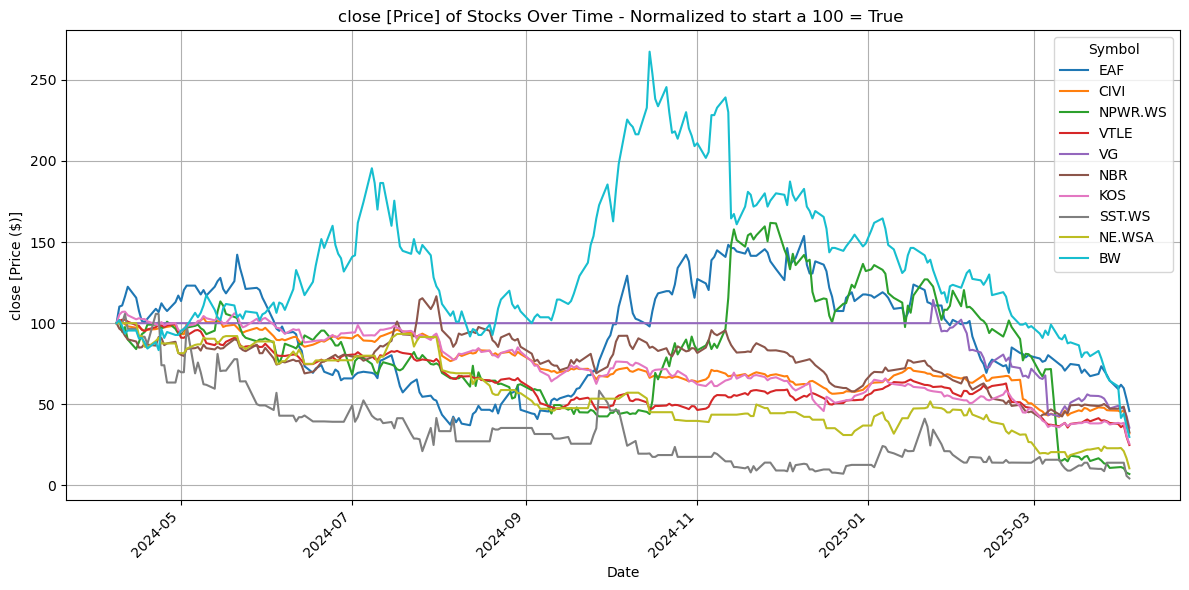

In [35]:
# Using loc to filter by the first level
# for other level use xs()
df_historical_data_bottom10 = df_historical_data.loc[final_data_complete.tail(10).index]
graph_evolution_per_timestamp(df_historical_data_bottom10)

## Calculating the Number of Shares to Buy

We'll use the `portfolio_input` function that we created earlier to accept our portfolio size. Then we will use similar logic in a `for` loop to calculate the number of shares to buy for each stock in our investment universe.

In [36]:
final_data_complete['Number of Shares to Buy'] = None
final_data_complete.head(12)

,1-day Return,1-week Return,1-month Return,3-month Return,6-month Return,1-year Return,1-day Return Percentile,1-week Return Percentile,1-month Return Percentile,3-month Return Percentile,6-month Return Percentile,1-year Return Percentile,HQM Score,Last Price,Number of Shares to Buy
symbol,,,,,,,,,,,,,,,
LOCL,0.684397,1.357320,1.305825,1.305825,0.900000,1.294686,1.000000,1.000000,1.000000,1.000000,0.990210,0.998187,0.998066,4.7500,None
NE.WS,0.028555,0.092177,0.092177,0.092177,0.161935,0.466923,0.976795,0.995286,0.995649,0.995649,0.940174,0.992748,0.982717,18.0100,None
AMPS,0.004032,0.008097,0.006061,0.006061,0.447674,0.223587,0.942531,0.963379,0.962292,0.962292,0.978970,0.973532,0.963832,4.9800,None
LITB,0.000000,0.597421,0.115000,0.115000,0.027650,0.327381,0.908086,0.999637,0.997825,0.997825,0.851342,0.987310,0.957004,2.2300,None
VHC,-0.015556,0.173510,0.198917,0.198917,0.390895,0.128662,0.771574,0.998187,0.998912,0.998912,0.976432,0.952139,0.949359,8.8600,None
TISI,0.053444,0.126031,0.130024,0.130024,-0.034831,0.507886,0.992023,0.996737,0.998187,0.998187,0.708122,0.993836,0.947849,19.1200,None
RKT,0.111913,0.181888,0.275891,0.275891,-0.043478,0.367673,0.997099,0.998550,0.999637,0.999637,0.680928,0.989485,0.944223,15.4000,None
GUT.PRC,0.032363,0.026057,0.035804,0.035804,0.023016,0.024019,0.980058,0.986222,0.990210,0.990210,0.844453,0.858593,0.941624,24.8593,None
FNA,-0.001530,0.000767,-0.000766,-0.000766,1.462264,0.263311,0.887600,0.937273,0.924220,0.924220,0.994199,0.980783,0.941383,13.0500,None


In [37]:
#portfolio_size = input('Enter the value of your portfolio: ')
portfolio_size = 50_000

try:
    val = float(portfolio_size)
except ValueError:
    print("That's not a number ! \nPlease try again")
    portfolio_size = input('Enter the value of your portfolio: ')
    val = float(portfolio_size)
        
#portfolio_input()
print(portfolio_size)

50000


In [38]:
position_size = float(portfolio_size)/10
print(position_size)

5000.0


In [39]:
count_stock = 0
max_stock = 10
for i in final_data_complete.index:
    count_stock +=1
    if count_stock <= max_stock:
        #final_data_complete.loc[i, 'Number of Shares to Buy'] = math.floor(
        #    position_size / final_data_complete.loc[i, 'Stock Price'])
        final_data_complete.loc[i, 'Number of Shares to Buy'] = position_size / final_data_complete.loc[i, 
                                                                                                        'Last Price'
                                                                                                       ]
    else:
        final_data_complete.loc[i, 'Number of Shares to Buy'] = 0

final_data_complete.head(12)

,1-day Return,1-week Return,1-month Return,3-month Return,6-month Return,1-year Return,1-day Return Percentile,1-week Return Percentile,1-month Return Percentile,3-month Return Percentile,6-month Return Percentile,1-year Return Percentile,HQM Score,Last Price,Number of Shares to Buy
symbol,,,,,,,,,,,,,,,
LOCL,0.684397,1.357320,1.305825,1.305825,0.900000,1.294686,1.000000,1.000000,1.000000,1.000000,0.990210,0.998187,0.998066,4.7500,1052.631579
NE.WS,0.028555,0.092177,0.092177,0.092177,0.161935,0.466923,0.976795,0.995286,0.995649,0.995649,0.940174,0.992748,0.982717,18.0100,277.623542
AMPS,0.004032,0.008097,0.006061,0.006061,0.447674,0.223587,0.942531,0.963379,0.962292,0.962292,0.978970,0.973532,0.963832,4.9800,1004.016064
LITB,0.000000,0.597421,0.115000,0.115000,0.027650,0.327381,0.908086,0.999637,0.997825,0.997825,0.851342,0.987310,0.957004,2.2300,2242.152466
VHC,-0.015556,0.173510,0.198917,0.198917,0.390895,0.128662,0.771574,0.998187,0.998912,0.998912,0.976432,0.952139,0.949359,8.8600,564.334086
TISI,0.053444,0.126031,0.130024,0.130024,-0.034831,0.507886,0.992023,0.996737,0.998187,0.998187,0.708122,0.993836,0.947849,19.1200,261.506276
RKT,0.111913,0.181888,0.275891,0.275891,-0.043478,0.367673,0.997099,0.998550,0.999637,0.999637,0.680928,0.989485,0.944223,15.4000,324.675325
GUT.PRC,0.032363,0.026057,0.035804,0.035804,0.023016,0.024019,0.980058,0.986222,0.990210,0.990210,0.844453,0.858593,0.941624,24.8593,201.131971
FNA,-0.001530,0.000767,-0.000766,-0.000766,1.462264,0.263311,0.887600,0.937273,0.924220,0.924220,0.994199,0.980783,0.941383,13.0500,383.141762


## Formatting Our Excel Output

We will be using the XlsxWriter library for Python to create nicely-formatted Excel files.

XlsxWriter is an excellent package and offers tons of customization. However, the tradeoff for this is that the library can seem very complicated to new users. Accordingly, this section will be fairly long because I want to do a good job of explaining how XlsxWriter works.

In [40]:
# clean time marker after 3 consecutive split with different seperator (to put in a function)
current_time_formatted_file = "".join(current_time_formatted.split(":")) 
current_time_formatted_file = "".join(current_time_formatted_file.split("-"))
current_time_formatted_file = "".join(current_time_formatted_file.split(" "))
    
writer = pd.ExcelWriter(f'output/momentum_strategy_all_data_{current_time_formatted_file}.xlsx', 
                        engine='xlsxwriter')
final_data_complete.to_excel(writer, sheet_name = 'Momentum Strategy', index = True)

## Creating the Formats We'll Need For Our .xlsx File

You'll recall from our first project that formats include colors, fonts, and also symbols like % and $. We'll need four main formats for our Excel document:

* String format for tickers
* \$XX.XX format for stock prices
* \$XX,XXX format for market capitalization
* Integer format for the number of shares to purchase

Since we already built our formats in the last section of this course, I've included them below for you. Run this code cell before proceeding.

In [41]:
background_color = '#0a0a23'
font_color = '#ffffff'

string_template = writer.book.add_format(
        {
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

dollar_template = writer.book.add_format(
        {
            'num_format':'$0.00',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

integer_template = writer.book.add_format(
        {
            'num_format':'0',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

percent_template = writer.book.add_format(
        {
            'num_format':'0.0%',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

In [42]:
column_formats = {
    'A':['Ticker', string_template],
    'B':['1-day Return', percent_template],
    'C':['1-week Return', percent_template],
    'D':['1-month Return', percent_template],
    'E':['3-month Return', percent_template],
    'F':['6-month Return', percent_template],
    'G':['1-year Return', percent_template],
    'H':['1-day Return Percentile', percent_template],
    'I':['1-week Return Percentile', percent_template],
    'J':['1-month Return Percentile', percent_template],
    'K':['3-month Return Percentile', percent_template],
    'L':['6-month Return Percentile', percent_template],
    'M':['1-year Return Percentile', percent_template],
    'N':['HQM Score', percent_template],
    'O':['Stock Price', dollar_template],
    'P':['Number of Shares to Buy', integer_template]
}

for column in column_formats.keys():
    writer.sheets['Momentum Strategy'].set_column(f'{column}:{column}',25, column_formats[column][1])
    writer.sheets['Momentum Strategy'].write(f'{column}1',column_formats[column][0], column_formats[column][1])

## Saving Our Excel Output

As before, saving our Excel output is very easy:

In [43]:
writer.close()

In [44]:
# Stop the timer
end_time = time.time()

# Print the current date and time in a human-readable format
current_time = datetime.fromtimestamp(end_time)
print("Current date and time:", current_time.strftime("%Y-%m-%d %H:%M:%S"))

# Calculate the elapsed time
elapsed_time = end_time - start_time
# Format the elapsed time into hours, minutes, and seconds
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

# Display the elapsed time
print(f"Total process time: {int(hours):02}:{int(minutes):02}:{int(seconds):02}")

Current date and time: 2025-04-07 11:10:39
Total process time: 00:02:46
